In [17]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os
from torchvision import models

In [29]:
# Configuraciones
device = torch.device('cpu' if torch.cuda.is_available() else 'cuda')
print(device)

model_path = '../models/re_fa_15_25e_64b.pth'
test_dir = '../data/preprocessed/test'
img_size = 224
batch_size = 64
num_images_to_test = 100  # por persona

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Cargar datos de test
dataset = ImageFolder(test_dir, transform=transform)

cpu


Classification Report:
                    precision    recall  f1-score   support

        Abir Ahmed       1.00      0.53      0.70        60
   Adriana Sanchez       0.50      0.85      0.63        60
 Adriana Solanilla       1.00      1.00      1.00        60
Alejandro Tulipano       0.00      0.00      0.00        60
      Amy Olivares       1.00      0.20      0.33        60
      Blas de Leon       1.00      0.40      0.57        60
     Carlos Beitia       0.22      1.00      0.36        60
  Carlos Hernandez       1.00      0.57      0.72        60
   Cesar Rodriguez       1.00      0.10      0.18        60
 Javier Bustamante       0.89      0.57      0.69        60
    Jeremy Sanchez       1.00      0.78      0.88        60
  Jonathan Peralta       0.00      0.00      0.00        60
   Kevin Rodriguez       0.22      1.00      0.37        60
       Mahir Arcia       1.00      0.03      0.06        60
    Michael Jordan       0.00      0.00      0.00        60

          accur

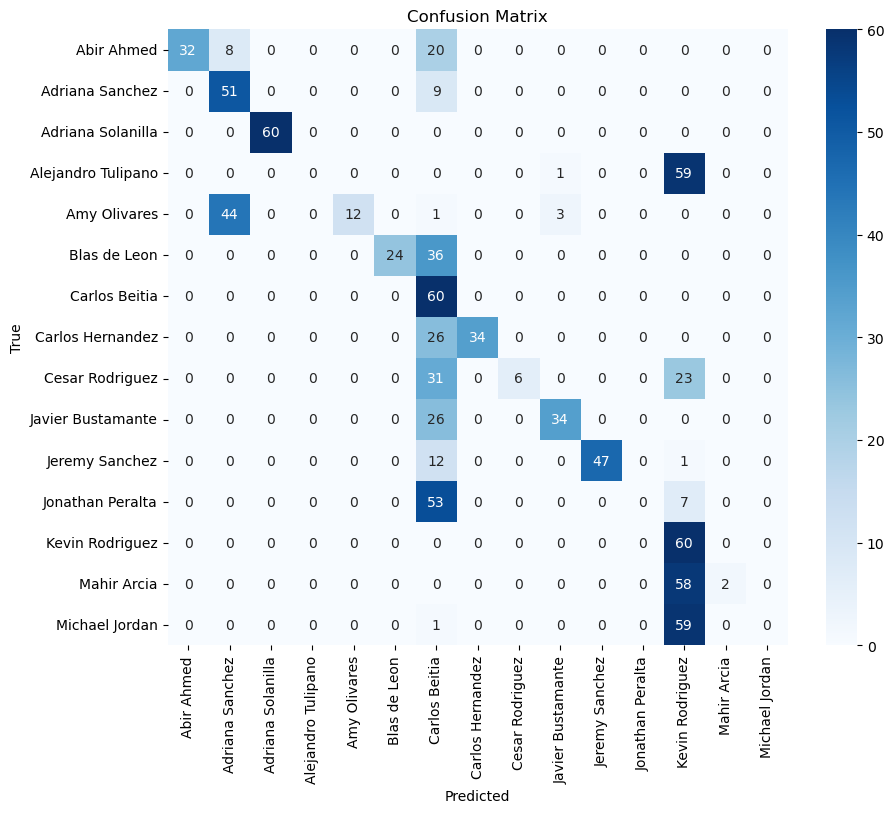

In [30]:
# Obtener 80 imágenes por clase
def sample_images_per_class(dataset, samples_per_class=100):
    targets = np.array(dataset.targets)
    indices = []
    for class_idx in range(len(dataset.classes)):
        class_indices = np.where(targets == class_idx)[0]
        selected = np.random.choice(class_indices, min(samples_per_class, len(class_indices)), replace=False)
        indices.extend(selected)
    return Subset(dataset, indices)

test_subset = sample_images_per_class(dataset, num_images_to_test)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

# Cargar modelo
model = models.mobilenet_v2(weights=None)
model.classifier[1] = torch.nn.Linear(model.last_channel, len(dataset.classes))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Reporte y matriz de confusión
class_labels = dataset.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_labels, zero_division=0))

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

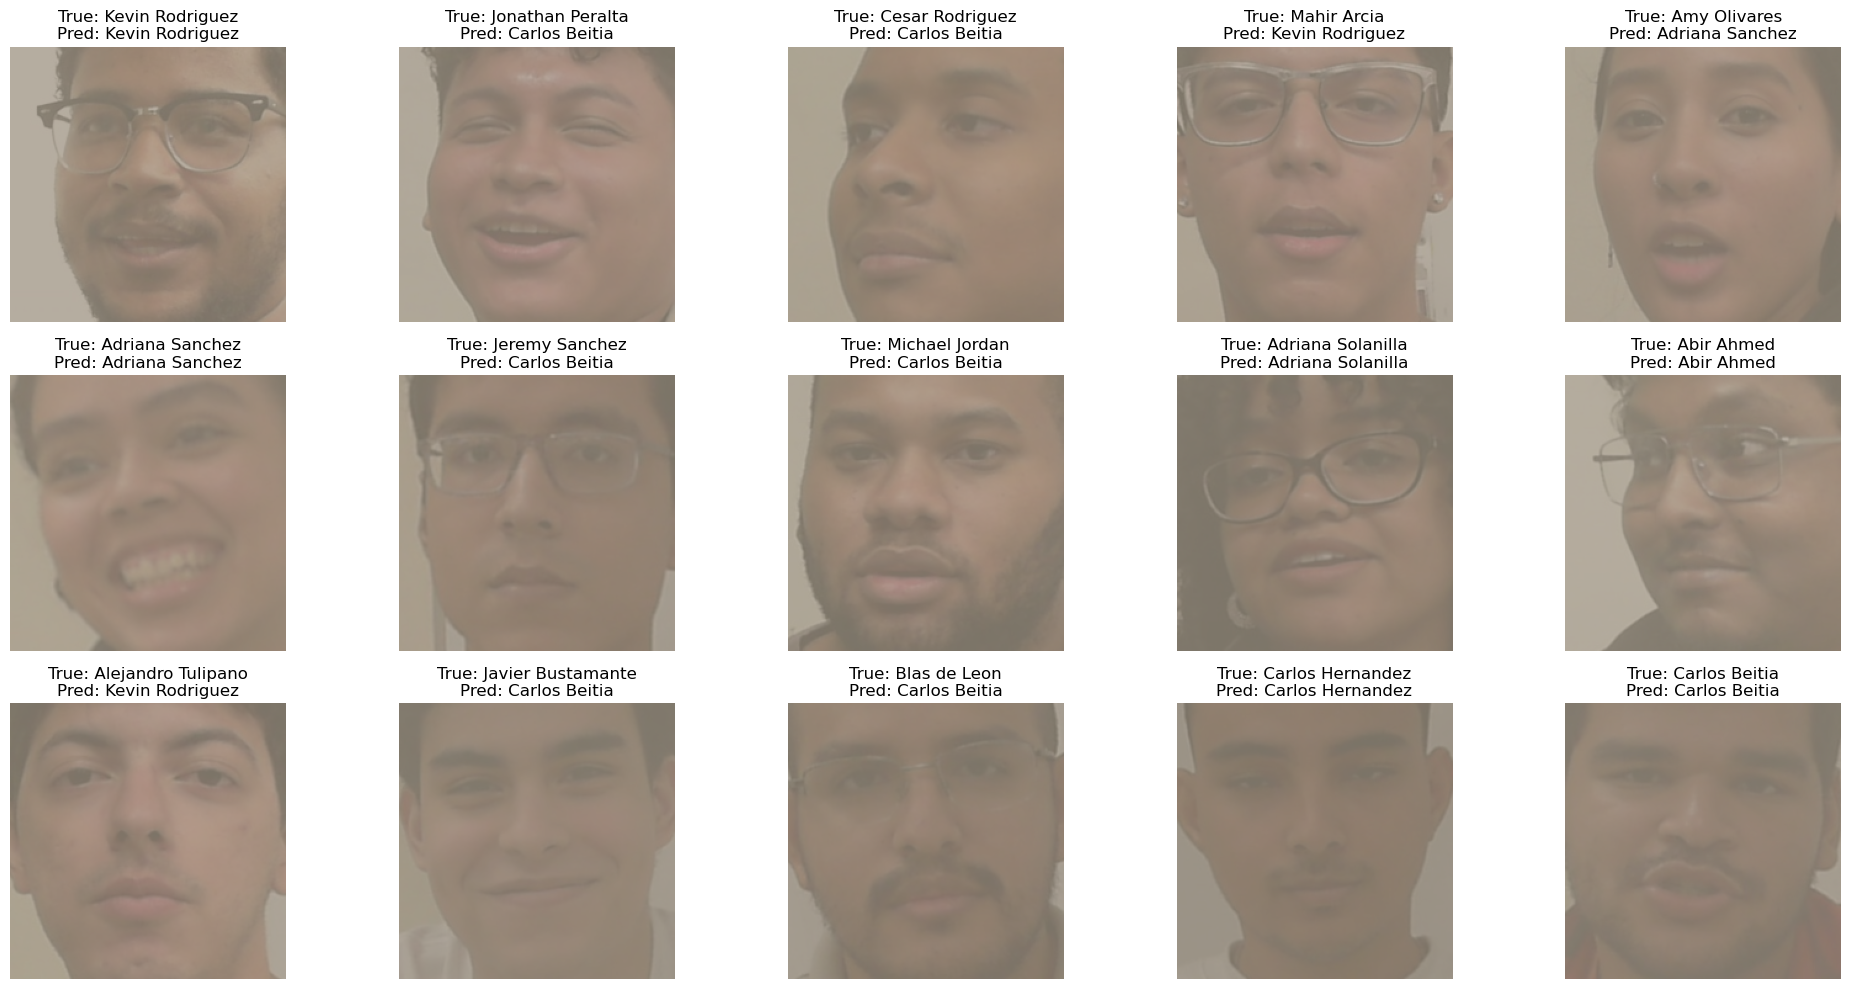

In [ ]:
def denormalize(image_tensor, mean, std):
    image = image_tensor.cpu().clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    image = image.permute(1, 2, 0).numpy()  # De (C, H, W) a (H, W, C)
    image = np.clip(image, 0, 1)  # Asegurar valores válidos
    return image

def plot_predictions(model, dataloader, class_labels, device, mean, std, num_images=15):
    model.eval()
    images_shown = 0
    shown_labels = set()
    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                true_label = labels[i].item()
                pred_label = preds[i].item()

                if true_label not in shown_labels:
                    shown_labels.add(true_label)
                    image = denormalize(inputs[i], mean, std)

                    plt.subplot(3, 5, images_shown + 1)
                    plt.imshow(image)
                    plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")
                    plt.axis('off')
                    images_shown += 1

                    if images_shown >= num_images:
                        plt.tight_layout()
                        plt.show()
                        return
                    

plot_predictions(model, test_loader, class_labels, device, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])